<a href="https://colab.research.google.com/github/saib7/Text_Summarization_of_conversation/blob/master/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.1 MB/s eta 0:00:0

In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.7 MB/s eta 0:00:00


In [1]:
!nvidia-smi

Wed Oct 11 04:32:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
dataset_samsum = load_dataset("samsum")
dataset_samsum

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [6]:
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

In [7]:
split_lengths

[14732, 819, 818]

In [8]:
print(f"Features: {dataset_samsum['train'].column_names}")

Features: ['id', 'dialogue', 'summary']


In [9]:
dataset_samsum['train']

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})

In [10]:
print("\nDialogue:")
print(dataset_samsum['train'][0])
print("\nDialogue:")
print(dataset_samsum['train'][1])


Dialogue:
{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

Dialogue:
{'id': '13728867', 'dialogue': 'Olivia: Who are you voting for in this election? \r\nOliver: Liberals as always.\r\nOlivia: Me too!!\r\nOliver: Great', 'summary': 'Olivia and Olivier are voting for liberals in this election. '}


In [11]:
print("\nDialogue:")
print(dataset_samsum['train'][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum['train'][0]["summary"])


Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Summary:
Amanda baked cookies and will bring Jerry some tomorrow.


In [12]:
print("\nDialogue:")
print(dataset_samsum['test'][1]["dialogue"])
print("\nSummary:")
print(dataset_samsum['test'][1]["summary"])


Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


In [13]:
dialogue = dataset_samsum['test'][0]["dialogue"]
dialogue

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [14]:
pipe = pipeline('summarization', model=model_ckpt)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
pipe_out = pipe(dialogue)
print(pipe_out)

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [16]:
from pprint import pprint
pprint(pipe_out)

[{'summary_text': 'Amanda: Ask Larry Amanda: He called her last time we were '
                  "at the park together .<n>Hannah: I'd rather you texted him "
                  '.<n>Amanda: Just text him .'}]


In [17]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [18]:
len(dataset_samsum["train"])

14732

In [19]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [20]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",  # it should be the dialogue
                               column_summary="highlights"): # ut should be the summary
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [21]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'],
                                    metric= rouge_metric,
                                    model= model_pegasus,
                                    tokenizer= tokenizer,
                                    column_text = 'dialogue',
                                    column_summary= 'summary',
                                    batch_size=8)

<ipython-input-21-fab5135c07fc>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


100%|██████████| 103/103 [18:14<00:00, 10.62s/it]


In [22]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015517,0.000298,0.015501,0.015512


Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


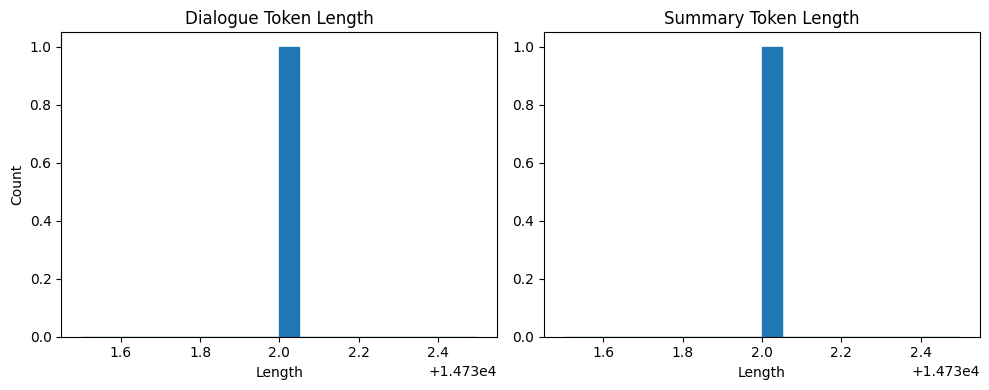

In [23]:
# Histogram
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [24]:

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3864: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [25]:
dataset_samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [26]:
dataset_samsum_pt['train'][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.',
 'input_ids': [12195,
  151,
  125,
  7091,
  3659,
  107,
  842,
  119,
  245,
  181,
  152,
  10508,
  151,
  7435,
  147,
  12195,
  151,
  125,
  131,
  267,
  650,
  119,
  3469,
  29344,
  1],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'labels': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1]}

In [27]:
tokenizer("Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)")

{'input_ids': [12195, 151, 125, 7091, 3659, 107, 842, 119, 245, 181, 152, 10508, 151, 7435, 147, 12195, 151, 125, 131, 267, 650, 119, 3469, 29344, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
with tokenizer.as_target_tokenizer():
  z = tokenizer("Amanda baked cookies and will bring Jerry some tomorrow.")
z

{'input_ids': [12195, 7091, 3659, 111, 138, 650, 10508, 181, 3469, 107, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [29]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [31]:

from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=2, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [32]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [33]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
500,1.631500,1.488017
1000,1.581500,1.403255
1500,1.348400,1.381197


Step,Training Loss,Validation Loss
500,1.631500,1.488017
1000,1.581500,1.403255
1500,1.348400,1.381197


TrainOutput(global_step=1840, training_loss=1.6447910236275713, metrics={'train_runtime': 5617.4535, 'train_samples_per_second': 5.245, 'train_steps_per_second': 0.328, 'total_flos': 1.105515010535424e+16, 'train_loss': 1.6447910236275713, 'epoch': 2.0})

In [34]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 410/410 [13:38<00:00,  2.00s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018464,0.00031,0.018329,0.018327


In [37]:
## Save model
model_pegasus.save_pretrained("/content/drive/MyDrive/NLP/saved_models/pegasus-samsum-model")

In [38]:
## Save tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/NLP/saved_models/tokenizer")

('/content/drive/MyDrive/NLP/saved_models/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/NLP/saved_models/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/NLP/saved_models/tokenizer/spiece.model',
 '/content/drive/MyDrive/NLP/saved_models/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/NLP/saved_models/tokenizer/tokenizer.json')

In [39]:
# Test
dataset_samsum = load_dataset("samsum")

In [40]:
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/NLP/saved_models/tokenizer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [42]:
sample_text

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [43]:
reference

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [44]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="/content/drive/MyDrive/NLP/saved_models/pegasus-samsum-model",tokenizer=tokenizer)


In [45]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [46]:
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)



Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
